# 2024 예능

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('./data_program/2024년 화제 예능.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20240512,❇️ 변우석 '뻔우석' 변신! '런닝맨'에서 펼쳐진 뻔뻔한 매력 분석 변우석의 뻔뻔...,<b>예능<\/b>재미 #<b>2024년<\/b>5월12일방송 #<b>예능<\/b>...,"변우석 '런닝맨'에서 '뻔우석' 변신!: SBS, 예능, 배고픔, 뻔우석, 식사 난..."
1,20240510,안녕하세요! 종합광고대행사 153프로덕션입니다. 2024년 하반기에도 다채로운 소재...,<b>2024년<\/b> 하반기에도 다채로운 소재의 <b>예능<\/b>이 방송될 예...,기대되는 신규예능 안내 - MBC 장안의 화제｜SBS 정글밥 ｜ENA 백종원의 레미...
2,20240206,출처 넷플릭스 코리아 2024년 넷플릭스 분기별 한국 오리지널 드라마 영화 예능 라...,영화 <b>예능<\/b> 라인업 정보 넷플릭스가 지난주 금요일 <b>2024년<\/...,2024년 넷플릭스 분기별 한국 오리지널 드라마 영화 예능 라인업 정보
3,20240418,"때는 2024년, 대유튜브의 시대를 지나 대OTT의 시대가 도래했으니. 영화, 드라...","때는 <b>2024년<\/b>, 대유튜브의 시대를 지나 대OTT의 시대가 도래했으니...",서바이벌 예능에서 연프 찍는다고 화제된 출연자.jpg
4,20240510,5월엔 새로운 예능이 정말 많은 것 같아요~! 대한민국 구석구석을 방문하는 예능이 ...,5월엔 새로운 <b>예능<\/b>이 정말 많은 것 같아요~! 대한민국 구석구석을 방...,"[엘크로] 2024년 5월 신규 예능 라인업, 세 번째!"


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'예능', '2024년', '화제', '방송', '출연', '드라마', '프로그램', '배우', '사람', '공개', '대하',
'모습', '영화', '시즌', '시작', '사랑', '활동', '생각', '콘텐츠', '인기', '작품', '이야기', '멤버',
'영상', '가수', '사진', '이후', '연기', '보이', '데뷔', '시청', '채널', '이후', '오리지널', '사람',
'활동', '출연진', '대상', '정보', '방송', '프로필', '추천', '나이', '예정', '이유', '대상',
'근황', '인스타', '배우', '한국', '소식', '출처', '연출', '진행', '이미지', '시리즈', '기대',
'다양', '감독', '제작', '마음', '때문', '공식', '오후', '방영', '장르', '올해', '활약', '라인업',
'시리즈', '종합', '기간', '진행', '프로', '출처', '최고', '신규', '공식', '안내'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 31.5 s
Wall time: 1min 21s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240512,변우석 뻔우석 변신 런닝맨에서 펼쳐진 뻔뻔한 매력 분석 변우석의 뻔뻔한 매력이 런닝...,b예능b재미 b2024년b5월12일방송 b예능b프로그램 유재석제자 변우석재탄생 b예...,변우석 런닝맨에서 뻔우석 변신 SBS 예능 배고픔 뻔우석 식사 난입 가성비 꼼수 기...,변 우석 뻔우석 변신 런닝맨 매력 분석 변 우석 매력 런닝맨 전국 거실 글 런닝맨 ...,재미 유재석 제자 변 우석 탄생 신동 식사 변우 석 런닝맨 웃음 폭탄 대세 변우 석...,변 우석 런닝맨 뻔우 변신 배고픔 뻔우석 식사 난입 가성비 꼼수 기술 유재석 먹방 ...
1,20240510,안녕하세요 종합광고대행사 153프로덕션입니다 2024년 하반기에도 다채로운 소재의 ...,b2024년b 하반기에도 다채로운 소재의 b예능b이 방송될 예정입니다 기대되는 신규...,기대되는 신규예능 안내 MBC 장안의 화제SBS 정글밥 ENA 백종원의 레미제라블 ...,안녕하세요 광고 대행사 프로덕션 하반기 소재 장 화요일 밤 시 전국 로컬 마스터 장...,하반기 소재 장 화요일 밤 시 전국 로컬 마스터 장윤정,장안 정글 밥 백종원 레미제라블 사생활 현무카세 차트 쇼 언더 커버 간접광고 문
2,20240206,출처 넷플릭스 코리아 2024년 넷플릭스 분기별 한국 오리지널 드라마 영화 예능 라...,영화 b예능b 라인업 정보 넷플릭스가 지난주 금요일 b2024년b 공개 예정 메인 ...,2024년 넷플릭스 분기별 한국 오리지널 드라마 영화 예능 라인업 정보,넷플릭스 코리아 넷플릭스 분기 넷플릭스 지나 주 금요일 메인 소개 올 해 분기 별 ...,넷플릭스 지나 주 금요일 메인 소개 자유 의미,넷플릭스 분기 별
3,20240418,때는 2024년 대유튜브의 시대를 지나 대OTT의 시대가 도래했으니 영화 드라마 예...,때는 b2024년b 대유튜브의 시대를 지나 대OTT의 시대가 도래했으니 영화 드라마...,서바이벌 예능에서 연프 찍는다고 화제된 출연자jpg,유튜브 시대 지나 대 시대 도래 와중 세계 거대 회사 넷플릭스 발표 인 탈출 말 게...,유튜브 시대 지나 대 시대 도래 순식간 이목 집중 작년 넷플릭스 강철 부대 우승,서바이벌 연프 출연자
4,20240510,5월엔 새로운 예능이 정말 많은 것 같아요 대한민국 구석구석을 방문하는 예능이 많이...,5월엔 새로운 b예능b이 정말 많은 것 같아요 대한민국 구석구석을 방문하는 b예능b...,엘크로 2024년 5월 신규 예능 라인업 세 번째,대한민국 구석구석 방문 번 소개 전국 팔도 로컬 마스터 장윤정 안정환 팝업 스토어 ...,대한민국 구석구석 방문 레전드 인생 순간 노래 노래,엘크 번


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('24예능_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
9850,연애,510
2508,넷플릭스,419
2685,뉴스,345
6139,봄날,326
609,결혼,305
7471,세계,292
11050,유튜브,290
11200,음악,286
548,게임,269
3092,대한민국,243


### [preprocessed_description]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
1433,연애,42
348,넷플릭스,30
94,결혼,26
1609,음악,23
231,금요일,21
1596,유튜브,20
1129,솔로,19
1356,야구,17
1971,지옥,17
2232,티빙,17


### [preprocessed_title]

In [13]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [14]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
1017,연애,31
254,넷플릭스,23
70,결혼,19
571,발표,13
966,야구,11
1135,유재석,11
277,뉴스,11
1588,펀덱스,11
530,미스트,10
1546,투어,10


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [15]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [16]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'연애': 510,
 '넷플릭스': 419,
 '뉴스': 345,
 '봄날': 326,
 '결혼': 305,
 '세계': 292,
 '유튜브': 290,
 '음악': 286,
 '게임': 269,
 '대한민국': 243,
 '스타': 241,
 '선수': 239,
 '대표': 239,
 '매력': 235,
 '솔로': 223,
 '서울': 223,
 '가족': 208,
 '관심': 206,
 '소개': 206,
 '기록': 204,
 '등장': 199,
 '광고': 199,
 '시청자': 198,
 '여행': 198,
 '남매': 197,
 '추리': 196,
 '브랜드': 192,
 '남자': 189,
 '야구': 189,
 '가능': 188,
 '일본': 187,
 '유재석': 186,
 '여자': 186,
 '가지': 185,
 '그룹': 184,
 '지옥': 184,
 '연예': 183,
 '캐릭터': 182,
 '친구': 182,
 '출신': 180,
 '이름': 177,
 '정도': 176,
 '티빙': 173,
 '졸업': 170,
 '맛집': 169,
 '출연자': 166,
 '무대': 165,
 '내용': 165,
 '인생': 164,
 '준비': 163,
 '커플': 163,
 '우석': 158,
 '환승': 157,
 '장면': 154,
 '작가': 152,
 '요양원': 150,
 '노래': 150,
 '일상': 149,
 '촬영': 147,
 '당시': 147,
 '부문': 147,
 '수상': 147,
 '사이': 146,
 '마지막': 145,
 '처음': 143,
 '재미': 143,
 '상황': 143,
 '여성': 143,
 '모델': 142,
 '최강': 141,
 '참가자': 140,
 '과거': 139,
 '경기': 139,
 '국내': 139,
 '인물': 137,
 '주연': 134,
 '선택': 134,
 '개인': 131,
 '역할': 131,
 '주목': 130,
 '결과': 129,
 '예고': 129,
 '후

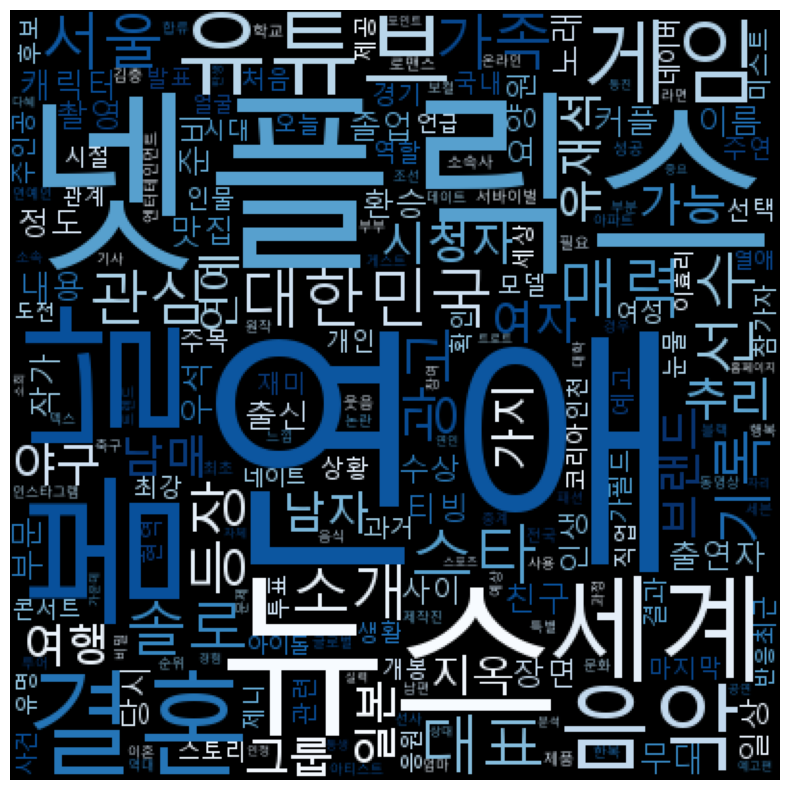

In [17]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

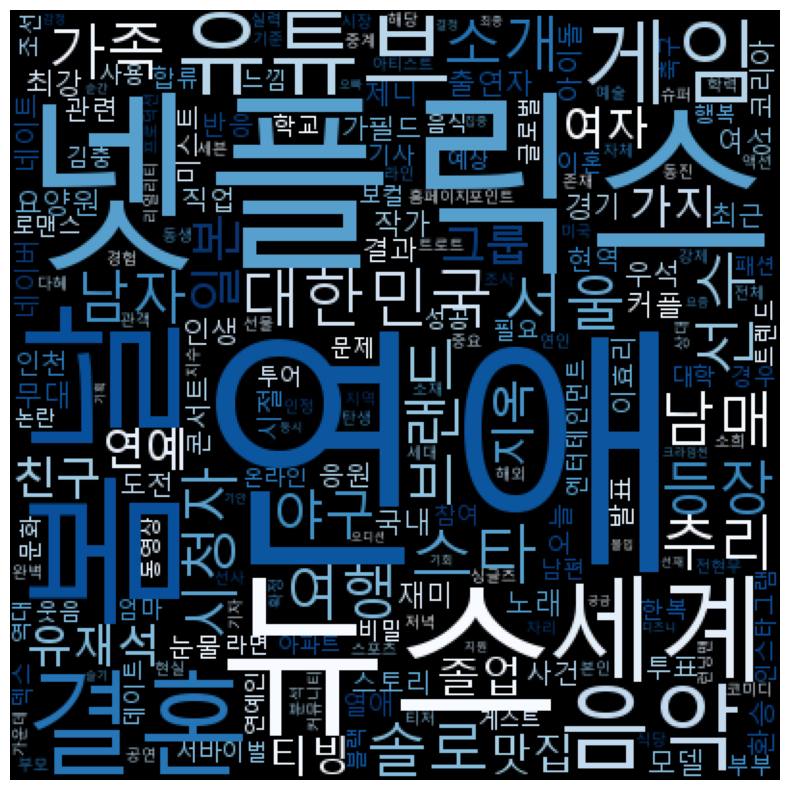

In [20]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'후보', '주인공', '정도', '관계', '관심', '내용', '부문', '유명',
             '주목', '인물', '얼굴', '준비', '시대', '처음', '언급', '확인', '과거',
             '사이',' 개봉', '장면', '일상', '매력', '가능', '선택', '주연', '이름',
             '세상', '소속사', '예고편', '원작', '예고', '당시', '기록', '제공',
             '참가자', '역할', '개봉', '제작진', '상황', '생활', '제품', '부분',
             '과정', '출신', '전국', '영상', '최초', '수상', '캐릭터', '광고',
             '촬영', '소속', '대표', '특별', '역할', '개인', '순위', '마지막'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [21]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'연애': 42,
 '넷플릭스': 30,
 '결혼': 26,
 '음악': 23,
 '금요일': 21,
 '유튜브': 20,
 '솔로': 19,
 '야구': 17,
 '지옥': 17,
 '티빙': 17,
 '졸업': 16,
 '대한민국': 16,
 '게임': 15,
 '선수': 14,
 '이효리': 14,
 '세계': 14,
 '현역': 13,
 '스타': 13,
 '순위': 12,
 '뉴스': 12,
 '환승': 12,
 '화요일': 12,
 '트렌드': 12,
 '시사': 12,
 '코리아': 12,
 '최근': 12,
 '커플': 11,
 '확정': 11,
 '서바이벌': 11,
 '학력': 11,
 '개봉': 11,
 '우석': 11,
 '리얼리티': 11,
 '추리': 11,
 '당시': 10,
 '연예': 10,
 '제니': 10,
 '중심': 10,
 '가족': 10,
 '발표': 10,
 '최강': 10,
 '특집': 10,
 '출연자': 10,
 '대표': 10,
 '등장': 9,
 '짝짓기': 9,
 '부작': 9,
 '대학': 9,
 '서울': 9,
 '일본': 9,
 '런닝맨': 9,
 '인생': 9,
 '예고편': 9,
 '남편': 9,
 '노래': 9,
 '기획': 9,
 '유재석': 9,
 '예술': 8,
 '레드카펫': 8,
 '조사': 8,
 '일상': 8,
 '퀴즈': 8,
 '유명': 8,
 '라디오': 8,
 '운세': 8,
 '덱스': 8,
 '기준': 8,
 '분기': 8,
 '소개': 8,
 '한일': 8,
 '상반기': 8,
 '광고': 8,
 '김호중': 7,
 '조선': 7,
 '시청자': 7,
 '우승': 7,
 '홍진호': 7,
 '출신': 7,
 '특별': 7,
 '새해': 7,
 '마지막': 7,
 '투어': 7,
 '가운데': 7,
 '걸그룹': 7,
 '저녁': 7,
 '싱글즈': 7,
 '신작': 7,
 '역할': 7,
 '주목': 7,
 '모델': 7,
 '목요일': 7,
 '여성': 7,
 '눈물'

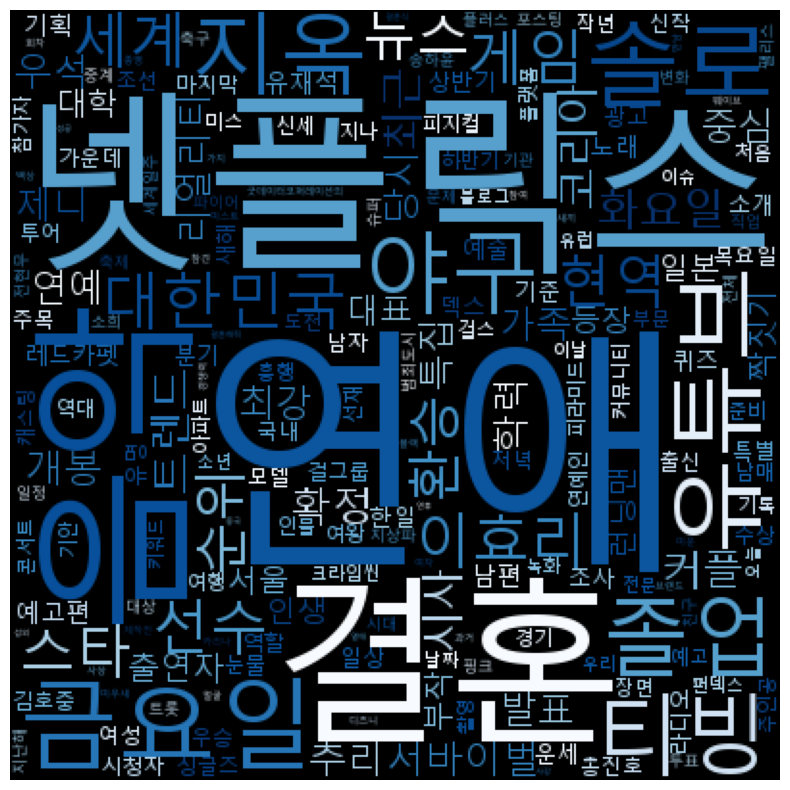

In [23]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

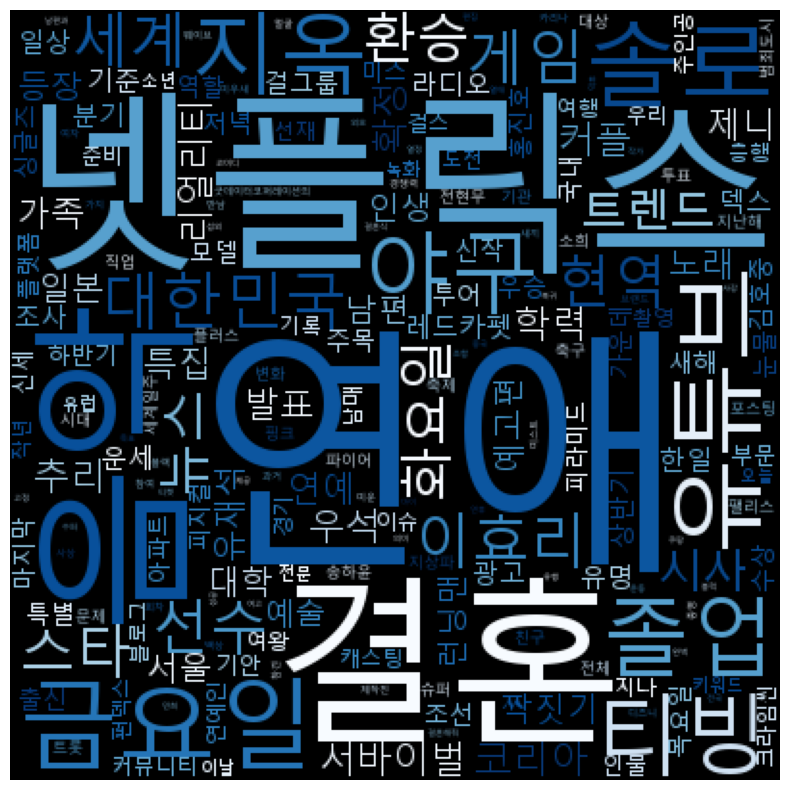

In [25]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'기획', '중계', '참가자', '개봉', '역대', '콘서트', '일정', '출연자',
             '순위', '최강', '대표', '남자', '특징', '퀴즈', '소개', '중심', '처음',
             '당시', '최근', '날짜', '부작', '예고', '장면', '여성', '시청자'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [26]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'연애': 31,
 '넷플릭스': 23,
 '결혼': 19,
 '발표': 13,
 '야구': 11,
 '유재석': 11,
 '뉴스': 11,
 '펀덱스': 11,
 '미스트': 10,
 '투어': 10,
 '환승': 10,
 '중계': 10,
 '티빙': 9,
 '남매': 9,
 '여행': 9,
 '솔로': 9,
 '맛집': 8,
 '직업': 8,
 '런닝맨': 8,
 '우석': 8,
 '덱스': 8,
 '오늘': 8,
 '커플': 8,
 '콘서트': 8,
 '현역': 7,
 '크라임씬': 7,
 '추리': 7,
 '일정': 7,
 '가족': 7,
 '광고': 7,
 '이효리': 7,
 '이혼': 7,
 '열애': 7,
 '서울': 7,
 '순위': 7,
 '대학': 6,
 '투표': 6,
 '패션': 6,
 '최강': 6,
 '여자': 6,
 '키워드': 6,
 '아파트': 6,
 '공지': 6,
 '슬기': 6,
 '금요일': 6,
 '스타': 6,
 '싱글즈': 6,
 '걸스': 6,
 '예술': 6,
 '게임': 6,
 '백상': 6,
 '제니': 6,
 '레드카펫': 5,
 '스틸': 5,
 '가격': 5,
 '서바이벌': 5,
 '운세': 5,
 '슈퍼': 5,
 '리얼리티': 5,
 '참가자': 5,
 '집안': 5,
 '코리아': 5,
 '급상승': 5,
 '브랜드': 5,
 '유퀴즈': 5,
 '재혼': 5,
 '폐지': 5,
 '팰리스': 5,
 '사장': 5,
 '눈물': 5,
 '예고편': 5,
 '논란': 5,
 '후보': 5,
 '소희': 5,
 '준비': 5,
 '지옥': 5,
 '선재': 5,
 '세계': 5,
 '인생': 5,
 '드레스': 4,
 '프랑스': 4,
 '시즌즈': 4,
 '소개': 4,
 '김승규': 4,
 '유튜브': 4,
 '분석': 4,
 '퀴즈': 4,
 '동생': 4,
 '대상': 4,
 '디즈니': 4,
 '컴백': 4,
 '일본': 4,
 '미스': 4,
 '여고': 4,
 '김진경': 4,
 '가사

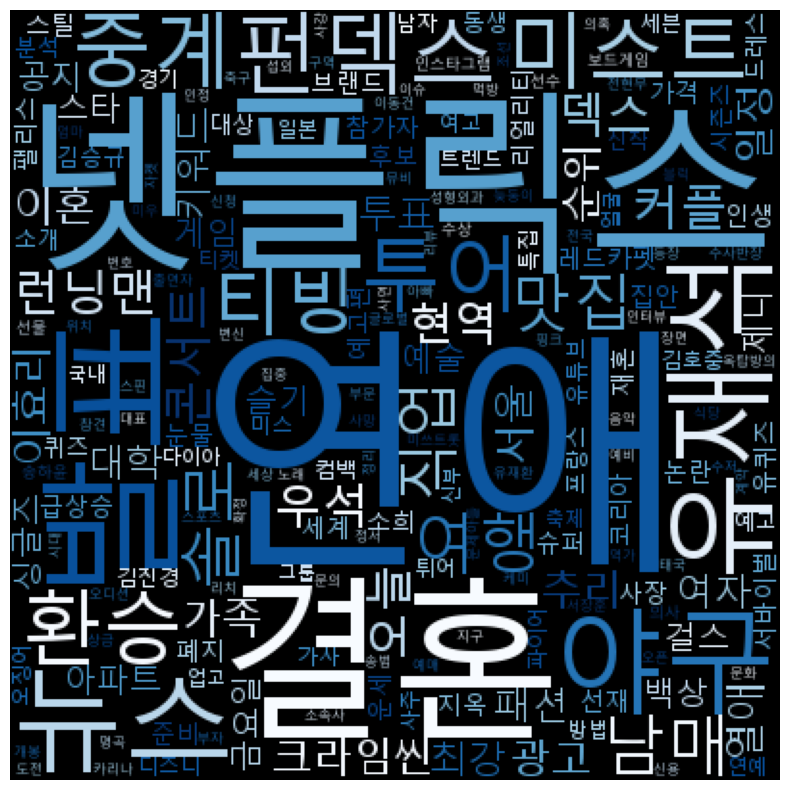

In [27]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

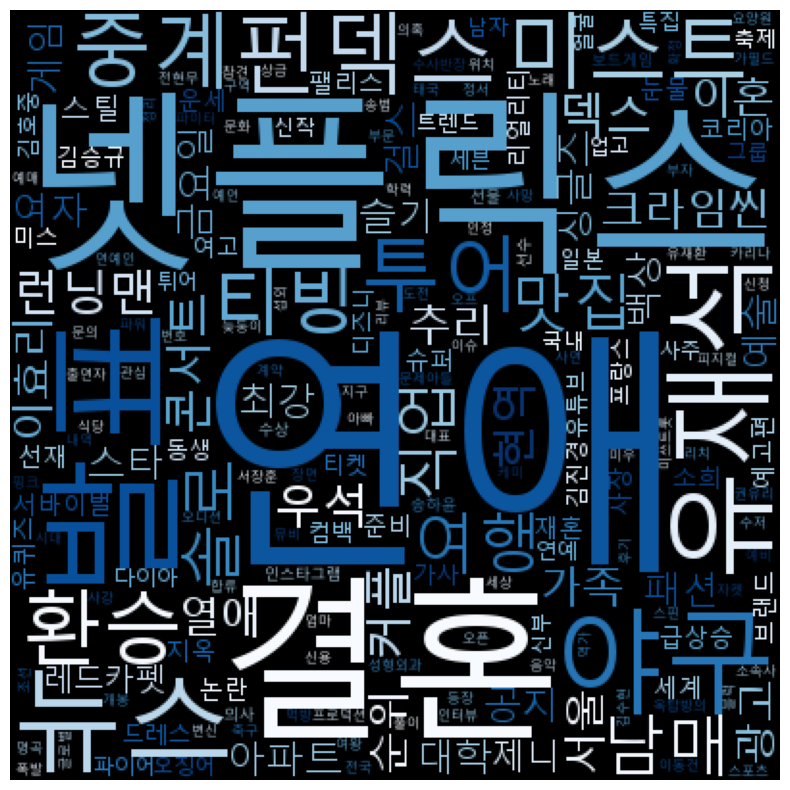

In [29]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'분석', '경기', '소개', '퀴즈', '폐지', '키워드', '대상', '참가자', '후보',
             '투표', '집안', '인생', '일정', '시즌즈', '가격', '집중', '오늘', '방법',
             '예고', '인생'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기